<a href="https://colab.research.google.com/github/JCaballerot/Recommender-Systems/blob/main/Autoencoder_Recommender/Autoencoder_Collaborative_Filtering_Last_fm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 align=center><font size = 5> ALS Collaborative Filtering - Last.fm </font></h1>

---

**Índice**

- 1. Introducción
- 2. Carga y Filtrado de Datos
- 3. Creación del Modelo Autoencoder Convolucional
- 4. Generación de Recomendaciones
- 5. Validación
- 6. Conclusiones


## 1. Introducción

En este laboratorio, exploraremos el uso de autoencoders convolucionales para generar recomendaciones en el ámbito de las interacciones entre usuarios y artistas en Last.fm. Los autoencoders son modelos de aprendizaje no supervisado que aprenden a reconstruir su entrada pasando por una representación latente más compacta, capturando así las características esenciales de los datos. Al incorporar capas convolucionales, el modelo puede detectar patrones locales y estructuras complejas en los datos, lo que es especialmente útil en conjuntos de datos con relaciones no lineales y distribuciones heterogéneas.



Instalamos las librerías necesarias.



In [ ]:
%%capture

# Instalación de librerías necesarias
!pip install tensorflow

# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models


## 2. Carga y Filtrado de Datos

Cargamos el dataset y aplicamos un filtro "long tail" para mejorar la calidad del análisis, manteniendo solo los artistas con al menos 50 escuchas. Este enfoque reduce el impacto de artistas menos populares y permite centrarse en recomendaciones más relevantes.

In [2]:
%%capture
# Descargar el dataset de Last.fm desde Kaggle
!pip install kaggle


In [ ]:

from google.colab import files
files.upload()  # Sube tu archivo kaggle.json aquí

# Configurar Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descargar y descomprimir el dataset de Last.fm
!kaggle datasets download -d japarra27/lastfm-dataset
!unzip lastfm-dataset.zip


In [4]:
# Cargar el dataset
data = pd.read_parquet("lastfm_union.parquet")[:10_000_000]


In [ ]:
data.head()

**Filtrado "long tail"**


In [5]:
# Contar las escuchas por artista
artist_listen_counts = data.groupby('artist_name').size().sort_values(ascending=False)


In [ ]:
artist_listen_counts

In [ ]:

# Visualizar distribución long tail
plt.figure(figsize=(12, 6))
plt.bar(range(len(artist_listen_counts)), artist_listen_counts, color='lightblue')
plt.title('Distribución del Número de Escuchas por Artista (Long Tail)')
plt.xlabel('Artistas ordenados por popularidad')
plt.ylabel('Número de escuchas')
plt.ylim(1, 4000)
plt.show()


In [8]:
# Filtrar artistas con al menos 100 escuchas
min_listens_per_artist = 100
popular_artists = artist_listen_counts[artist_listen_counts >= min_listens_per_artist].index
data_filtered = data[data['artist_name'].isin(popular_artists)]


In [ ]:
# Filtrar usuarios con al menos 100 escuchas
users_listen_counts = data_filtered.groupby('user_id').size().sort_values(ascending=False)
users_listen_counts

In [11]:
# Filtrar usuarios con al menos 100 escuchas
min_listens_per_user = 100
popular_users = users_listen_counts[users_listen_counts >= min_listens_per_user].index
data_filtered = data_filtered[data_filtered['user_id'].isin(popular_users)]


In [ ]:
data_filtered.groupby('user_id').size().sort_values(ascending=False).tail()

In [ ]:
data_filtered.groupby('artist_name').size().sort_values(ascending=False).tail()

## 3. Muestreo de datos

Ahora que tenemos los datos filtrados, procederemos a entrenar un modelo de recomendación usando ALS con la biblioteca surprise. En surprise, podemos utilizar el algoritmo BaselineOnly con el método de estimación configurado como ALS.

Primero, preparamos los datos en el formato que requiere surprise.

In [ ]:
# Crear el DataFrame con el recuento de escuchas
user_artist_df = data_filtered.groupby(['user_id', 'artist_name']).size().reset_index(name='listens')
user_artist_df

In [ ]:
# Calcular el rango intercuartílico
Q1 = user_artist_df['listens'].quantile(0.25)
Q3 = user_artist_df['listens'].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f'Upper limit: {upper_bound}')

# Ajustar valores fuera del rango
user_artist_df['listens_cap'] = user_artist_df['listens'].clip(lower=lower_bound, upper=upper_bound)
user_artist_df.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Crear una función para escalar listens por cada user_id
def scale_listens(df):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df['scaled_listens'] = df.groupby('user_id')['listens_cap'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
    return df

# Aplicar la función al DataFrame
scaled_user_artist_df = scale_listens(user_artist_df)
scaled_user_artist_df.head()

In [ ]:
scaled_user_artist_df[scaled_user_artist_df.user_id == 'user_000010'].scaled_listens.hist()

**División del Conjunto de Datos**


In [88]:
# Dividir en conjuntos de entrenamiento y prueba estratificando por usuario
train_data, test_data = train_test_split(scaled_user_artist_df,
    test_size = 0.3,
    random_state = 42,
    stratify = scaled_user_artist_df['user_id']
)

watchlist_data, test_data = train_test_split(test_data,
    test_size = 0.5,
    random_state = 42,
    stratify = test_data['user_id']
)

## 4. Creación del Modelo Autoencoder Convolucional

Implementaremos un autoencoder convolucional. Los autoencoders son modelos que aprenden a reconstruir su entrada pasando por una representación latente más pequeña, capturando así las características más importantes de los datos. Al utilizar convoluciones, el modelo puede capturar patrones locales en las interacciones usuario-artista.

### 4.1 Preparación de los Datos para el Autoencoder

Primero, necesitamos preparar los datos en un formato adecuado para el autoencoder. Esto implica crear una matriz de interacción usuario-artista donde cada fila representa un usuario y cada columna representa un artista

In [ ]:
train_data.head()

In [90]:
# Crear la tabla pivot con `user_id` como índice, `artist_name` como columnas y `scaled_listens` como valores
interaction_matrix = train_data.pivot(index='user_id', columns='artist_name', values='scaled_listens').reset_index()
watchlist_matrix = watchlist_data.pivot(index='user_id', columns='artist_name', values='scaled_listens').reset_index()

# Llenar los valores faltantes con 0
interaction_matrix.fillna(0, inplace=True)
watchlist_matrix.fillna(0, inplace=True)

In [ ]:
interaction_matrix.head()

### 4.2 Construcción del Autoencoder Convolucional


Ahora construiremos el modelo del autoencoder convolucional utilizando TensorFlow y Keras.

In [115]:
interaction_matrix = train_data.pivot(index='user_id', columns='artist_name', values='scaled_listens').fillna(0).values
watchlist_matrix = train_data.pivot(index='user_id', columns='artist_name', values='scaled_listens').fillna(0).values

In [ ]:
interaction_matrix.shape

In [ ]:
watchlist_matrix.shape

In [150]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:


# Expandir dimensiones para incluir batch size y canales
interaction_matrix_reshaped = interaction_matrix[np.newaxis, ..., np.newaxis]  # (1, 516, 9859, 1)
watchlist_matrix_reshaped = watchlist_matrix[np.newaxis, ..., np.newaxis]  # (1, 516, 9859, 1)

# Definir el modelo
input_layer = layers.Input(shape=(interaction_matrix_reshaped.shape[1], interaction_matrix_reshaped.shape[2], 1))

# Codificador
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # Reduce la dimensión a la mitad
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # Reduce la dimensión a la mitad

# Decodificador
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D(size=(2, 2))(x)  # Duplica la dimensión
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D(size=(2, 2))(x)  # Duplica la dimensión

# Capa de salida
output_layer = layers.Conv2D(1, kernel_size=(3, 3), activation = 'sigmoid', padding='same')(x)

# Recortar la salida para igualar las dimensiones de entrada
output_layer = layers.Cropping2D(cropping=((0, x.shape[1] - input_layer.shape[1]),
                                           (0, x.shape[2] - input_layer.shape[2])))(output_layer)

# Construir y compilar el modelo
autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')


autoencoder.summary()

### 4.3 Entrenamiento del Modelo


Entrenamos el autoencoder utilizando únicamente train_data.

In [ ]:
# Definir Early Stopping
early_stopping = EarlyStopping(
    monitor = 'loss',  # Monitorea la pérdida del conjunto de entrenamiento
    patience = 10,      # Espera 3 épocas sin mejora antes de detenerse
    restore_best_weights = True  # Restaura los mejores pesos obtenidos
)

# Entrenar el modelo con Early Stopping
history = autoencoder.fit(
    interaction_matrix_reshaped, interaction_matrix_reshaped,
    validation_data=(watchlist_matrix_reshaped, watchlist_matrix_reshaped),  # Validación explícita
    epochs=20,
    batch_size=1,
    verbose=1,
    callbacks=[early_stopping]
)


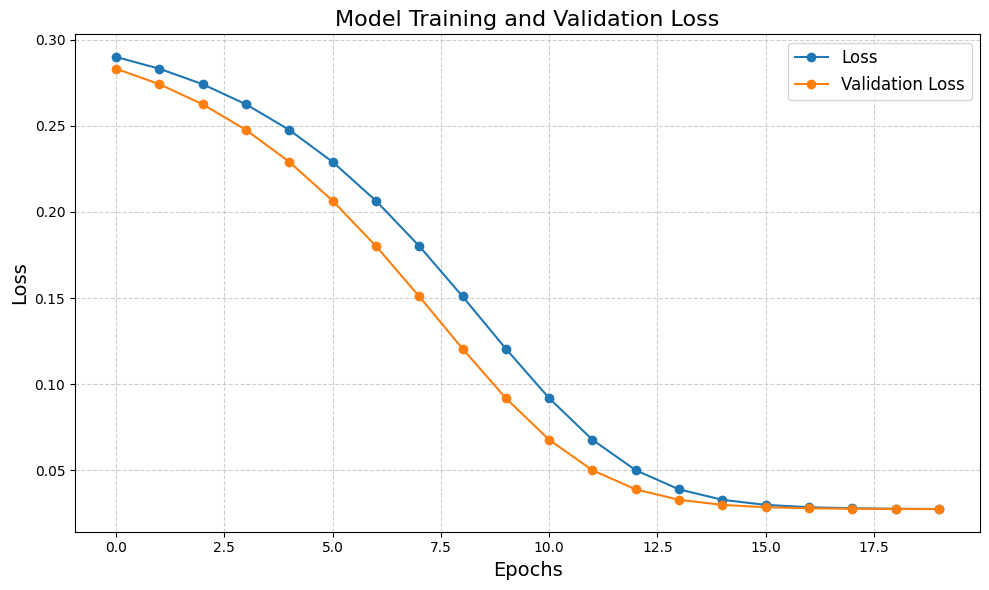

In [153]:
import matplotlib.pyplot as plt

# Graficar el desempeño de la red
plt.figure(figsize=(10, 6))

# Pérdida del entrenamiento
plt.plot(history.history['loss'], label='Loss', marker='o')

# Pérdida de validación (si está disponible)
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')

# Configuración de la gráfica
plt.title('Model Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Mostrar gráfica
plt.show()


## 5. Generación de Recomendaciones



### 5.1 Reconstrucción de la Matriz de Interacción


Obtenemos las predicciones del modelo para todos los usuarios en train_data.



In [154]:
user_ids = train_data.user_id.drop_duplicates().tolist()
artist_names = train_data.artist_name.drop_duplicates().tolist()
user_ids.sort()
artist_names.sort()

In [195]:
# Reconstruir la matriz de interacción
reconstructed = autoencoder.predict(interaction_matrix_reshaped)

# Remover dimensiones adicionales para devolver al formato original
reconstructed = np.squeeze(reconstructed, axis=(0, -1))  # Elimina las dimensiones de batch y canales

# Convertir a DataFrame etiquetado
reconstructed_df = pd.DataFrame(reconstructed, index=user_ids, columns=artist_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
# Reconstruir el DataFrame original desde reconstructed_df
reconstructed_df = reconstructed_df.reset_index()

original_format_df = reconstructed_df.melt(
    id_vars="index",
    var_name="artist_name",
    value_name="predict"
)
original_format_df = original_format_df.rename(columns={"index" :  "user_id"})

original_format_df.head()


In [ ]:
pddfRes = pd.merge(test_data, original_format_df, on = ['user_id', 'artist_name'], how = 'left')
pddfRes[pddfRes.user_id == 'user_000001'].sort_values('predict', ascending = False).head(10)


In [ ]:
# Crear la columna que indica si le gustó la canción
pddfRes['liked'] = pddfRes['scaled_listens'] > 0  # True si scaled_listens > 0, False en caso contrario

# Crear la columna de recomendación
pddfRes['rank'] = pddfRes.groupby('user_id')['predict'].rank(method='first', ascending=False)

# Generar la columna 'recommendation' indicando si la canción está entre las 10 mejores predicciones
pddfRes['recommendation'] = pddfRes['rank'] <= 10  # True si está en el top 10, False en caso contrario

# Mostrar las primeras filas del DataFrame actualizado
pddfRes.head()


In [ ]:
# Filtrar las recomendaciones hechas
recommended = pddfRes[pddfRes['recommendation'] == True]

# Filtrar las recomendaciones que realmente le gustan al cliente
liked_recommendations = recommended[recommended['liked'] == True]

# Calcular la cantidad de recomendaciones que le gustan
total_liked_recommendations = liked_recommendations.shape[0]

# Calcular el total de recomendaciones hechas
total_recommendations_made = recommended.shape[0]

# Proporción de recomendaciones que le gustan
liked_ratio = total_liked_recommendations / total_recommendations_made if total_recommendations_made > 0 else 0

# Mostrar resultados
total_liked_recommendations, total_recommendations_made, liked_ratio


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(pddfRes.dropna()['liked'], pddfRes.dropna()['predict'])